In [1]:
import pandas as pd
from encode_desc import transform_description, tokenize_description

### Pre-model training

#### Load data

In [ ]:
df_test = pd.read_pickle("./c_test_V2.1.pkl")
df_test["set"] = 'test'
df = pd.read_pickle("./c_train_V2.1.pkl")
df["set"] = 'train'
print(len(df))
df = pd.concat([df, df_test])
print(len(df))
df.sample(10)

In [ ]:

print(len(df))
df = df.drop_duplicates(subset='description_text').reset_index(drop=True)
df = df.drop(columns=["index"])
df["vote_caller"] = df["vote_caller"].astype(str)
print(len(df))
df.head(5)

In [ ]:
# Uncomment if only want to run on smaller sample
#df = df.sample(60, random_state=42).reset_index(drop=True)

#### Tokenize vote-summaries

In [ ]:
df_tokenized = tokenize_description(df, "Venstre", "../BL/models_binary_party/", True)
print(len(df_tokenized))
df_tokenized.head(3)

#### Transformation (party probs)
transform tokenized vote-summaries into party probs (for the 9 chosen parties)

In [ ]:
parties = ["Alternativet", "Dansk Folkeparti", "Det Konservative Folkeparti", "Det Radikale Venstre", "Enhedslisten", "Liberal Alliance", "Socialdemokratiet", "Socialistisk Folkeparti" ,"Venstre"]
df_trans = df_tokenized
for party in parties:
    df_trans = transform_description(df_trans, party, "../../../../Models/binary/", 2, True)

df_trans.head(3)
## On GPU Jonathan PC 2 30s per party

In [ ]:
df_trans.to_pickle("c_all_w_party_probs_v2.1.pkl")

#### Transformation (Word2Vec embeddings)
add 500d Word2Vec embeddings for vote-summaries

In [ ]:
df_trans = pd.read_pickle("./c_all_w_party_probs_v2.1.pkl")
import os
os.chdir("../")

In [ ]:
import word_tokenizer
import pandas as pd
from gensim import models

In [ ]:
df_trans.head(1)

In [ ]:
## Remove stopwords and lemmatize
df_trans['description_filtered'] = df_trans['description_text'].apply(lambda x: word_tokenizer.tokenize(x))

In [ ]:
df_trans.head(1)

In [ ]:
## Gustav
#MODEL_FILE = '../dsl_skipgram_2020_m5_f500_epoch2_w5.model/dsl_skipgram_2020_m5_f500_epoch2_w5.model'

## Jonathan
MODEL_FILE = '../../../Models/word2vec/dsl_skipgram_2020_m5_f500_epoch2_w5.models/dsl_skipgram_2020_m5_f500_epoch2_w5.model'
model = models.Word2Vec.load(MODEL_FILE)

## Used for vectorizing the description text (filtered)
words = set(model.wv.index_to_key)

In [ ]:
'''def vec_summary(row):
    val = model.wv['start']
    for word in row:
        try:
            val = val + model.wv[word]
        except:
            print(word)
    return val.mean(axis=0)

v0 = vec_summary(df_trans["description_filtered"][0])
v1 = vec_summary(df_trans["description_filtered"][1])'''

In [ ]:
import numpy as np
X_train_vect = np.array([np.array([model.wv[i] for i in ls if i in words])
                         for ls in df_trans["description_filtered"]])


In [ ]:
# Why is the length of the sentence different than the length of the sentence vector?
for i, v in enumerate(X_train_vect):
    print(len(df_trans["description_filtered"].iloc[i]), len(v))


In [ ]:
X_train_vect_avg = []
for v in X_train_vect:
    if v.size:
        X_train_vect_avg.append(v.mean(axis=0))
    else:
        X_train_vect_avg.append(np.zeros(100, dtype=float))

In [ ]:
# Are our sentence vector lengths consistent?
for i, v in enumerate(X_train_vect_avg):
    print(len(df_trans["description_filtered"].iloc[i]), len(v))

In [ ]:
#v_un = v0 - v1
#print(model.wv.most_similar(positive=[v_un])[:3])
#print(model.wv.most_similar(positive=[v0])[:3])
#print(model.wv.most_similar(positive=[v1])[:3])

## Outputs:
## Please note: both meetings, based on their word vectors are energy related: lets check
'''
[('udarbejdelsen', 0.16276699304580688), ('odenseafdeling', 0.15484489500522614), ('udarbejdelse', 0.14360615611076355)]
[('sundhedsovervågning', 0.8051859140396118), ('sdgerne', 0.8033974766731262), ('kystmøller', 0.7973899841308594)]
[('kulstoffattig', 0.7970796823501587), ('vindkraftel', 0.7832463383674622), ('ikkefossil', 0.782241940498352)]
'''

In [ ]:
#print(df_trans["description_text"][0])
#print(df_trans["description_text"][1])

## Outputs:
'''
Beslutningsforslaget gik ud på, at regeringen skulle udarbejde et nyt program for udnyttelse af bølgeenergi. Programmet skulle støtte udvikling og afprøvning af nye bølgekraftmodeller og bl.a. etablere prøvestationer på havet. Der skulle endvidere gives økonomisk støtte til etablering og drift af bølgekraftanlæg og sikres en fast, høj afregningspris for den producerede strøm.
Beslutningsforslaget gik ud på at fritage elektricitet, der produceredes af vedvarende energikilder, for CO2-afgift. Der blev lagt CO2-afgift oven i elprisen, hvad enten elektriciteten var produceret ved vedvarende energi eller ved kul eller andre fossile energikilder. Ved at fritage elektricitet, der produceredes ved vedvarende energikilder, ville udbydere, der satsede på vedvarende energi, kunne få en markedsfordel.
'''

## As seen this is exactly the case!

In [ ]:
df_trans2 = df_trans
df_trans2["vec"] = X_train_vect_avg

In [ ]:
df_trans2.head(5)

#### Expand to per politician

In [ ]:
view = df_trans2.drop(columns=["description", "votes_by_party", "url", "input_ids", "token_type_ids", "attention_mask"])
view.columns

In [ ]:
weights_available = ["Alternativet", "Dansk Folkeparti", "Det Konservative Folkeparti", "Det Radikale Venstre", "Enhedslisten", "Liberal Alliance", "Socialdemokratiet", "Socialistisk Folkeparti" ,"Venstre"]

view["vec"] = view["vec"].astype(str)

In [ ]:
expanded_view1 = pd.DataFrame(columns=['date', 'description', 'politician', 'vote','vote_caller', 'y_pred', 'set',
                                        ## Transformation 1 use the 'weigths_available' from above
                                        'vec', ## Transformation 2,
                                        'vote_id' ## For back tracking
                                        ])

for index, row in view.iterrows():
    
    
    try:
        temp = pd.DataFrame(view['votes'][index])
        temp['description'] = view['description_text'][index]
        temp['date'] = view['date'][index]
        temp['vote_caller'] = view['vote_caller'][index]
        temp['y_pred'] = view['y_pred'][index]
        temp['set'] = view['set'][index]
        temp['vote_id'] = view['vote_id'][index]

        ## Trans 1
        for party in weights_available:
            temp[f"{party}_weight_for"] = view[f"{party}_weight_for"][index]
            temp[f"{party}_weight_against"] = view[f"{party}_weight_against"][index]
        
        ## Trans 2
        temp['vec'] = view['vec'][index]
        #temp['party'] = temp.apply(lambda row: find_party(row), axis=1)
        
        expanded_view1 = temp.append(expanded_view1)
    
    except:
        temp['description'] = view['description_text'][index]
        temp['date'] = view['date'][index]
        print("error")
    
#expanded_view1.head(20)

In [ ]:
expanded_view1 = expanded_view1.reset_index(drop=True)

##### Convert word2vec back to right format

In [ ]:
from ast import literal_eval
import re
def str2list(row):
    string = row
    string = re.sub(r"\[\s+", "[",string)
    string = re.sub(r"\s+\]", "]",string)
    string = re.sub(r"\s+", ",",string)
    list = literal_eval(string)
    return list

assert(str2list("[ -3.2    4.3    ]")==[-3.2,4.3])

In [ ]:
expanded_view1["vec2"] = expanded_view1.apply(lambda row: str2list(row["vec"]),axis=1)
#expanded_view1.head(10)

##### Select the right party probabilities

In [ ]:
import numpy as np

def set_weights_for(row):
    try:
        party = row["party"].split(" (")[0]
        w = row[f"{party}_weight_for"]
        return w
    except:
        return row[f"Venstre_weight_for"]

def set_weights_against(row):
    try:
        party = row["party"].split(" (")[0]
        w = row[f"{party}_weight_against"]
        return w
    except:
        return row[f"Venstre_weight_against"]


In [ ]:
expanded_view1["w_for"] = expanded_view1.apply(lambda row: set_weights_for(row), axis=1)
expanded_view1["w_against"] = expanded_view1.apply(lambda row: set_weights_against(row), axis=1)

df_trans3 = expanded_view1
df_trans3.sample(5)

##### Create party cols

In [ ]:
def find_party1(row):
    party = row.split("(")[1]
    return ("(" + party).strip()

def find_party2(row):
    party = row.split("(")
    if len(party)==1:
        #print(party)
        return "(MISSING)"
    else:
        return (("(" + party[1]).split(")")[0])+")"

df_trans3["party2"] = df_trans3.apply(lambda row: find_party1(row["party"]), axis=1)
df_trans3["vote_caller2"] = df_trans3.apply(lambda row: find_party2(row["vote_caller"]), axis=1)
df_trans3.head(1)

##### Select only 'For' and 'Imod' and right parties

In [ ]:
parties = '(ALT)', '(DF)', '(EL)', '(KF)', '(LA)', '(RV)', '(S)', '(SF)','(V)'
print(len(df_trans3))
df_trans4 = df_trans3[df_trans3["party2"].isin(parties)]
print(len(df_trans4))
df_trans4["party2"].unique()

In [ ]:
df_trans4 = df_trans4[df_trans4["vote"]!="Fraværende"]
df_trans4 = df_trans4[df_trans4["vote"]!="Hverken for eller imod"]
print(len(df_trans4))
df_trans4["vote"].unique()

### Add politician embeddings and calculate cos_sim

In [ ]:
pol_c = pd.read_pickle("../data_analysis/pol2vec.pkl")
df_trans4["politician"] = df_trans4["politician"].str.strip()
df_trans5 = df_trans4.merge(pol_c[["politician", "vec"]], how="left", on=["politician"])

## Drop all politicians without vec --> TODO: add interpolation to party average
print(len(df_trans5))
df_trans5 = df_trans5[df_trans5["vec_y"].notna()].reset_index(drop=True)
print(len(df_trans5))


In [ ]:
## Calcuate Cosine similarity
def cosine_similarity(row):
    v_vote = row["vec2"]
    v_politician = row["vec_y"]
    return model.wv.cosine_similarities(v_vote,[v_politician])[0]

df_trans5["cos_sim"] = df_trans5.apply(lambda row: cosine_similarity(row), axis=1)

In [ ]:
df_trans5["cos_sim"].describe()

In [ ]:
## Final look at DF before pipeline
df_trans5.sample(4)
df_trans5.to_pickle("c_all_trans_v2.1.pkl")
df_trans5[df_trans5["set"]!="train"]


### Model training
+ choose features
+ feed into SK-pipeline
+ train a random forest model
+ gg

In [106]:
import pandas as pd
df_trans5 = pd.read_pickle("./c_all_trans_v2.1.pkl")


In [107]:
print(df_trans5["party2"].unique())
df_trans5.head(1)

['(LA)' '(SF)' '(S)' '(DF)' '(KF)' '(V)' '(EL)' '(RV)' '(ALT)']


,party,politician,vote,description,date,vote_caller,y_pred,set,vote_id,Alternativet_weight_for,...,Venstre_weight_for,Venstre_weight_against,vec_x,vec2,w_for,w_against,party2,vote_caller2,vec_y,cos_sim
0,Liberal Alliance (LA),Anders Samuelsen,For,Folketinget tager ministerens redegørelse til ...,2009-02-03,['Henriette Kjær (KF)' 'Johs. Poulsen (RV)' 'K...,climate,test,"Afstemning nr. 185, 2008-09",0.777311,...,0.889158,0.110842,[-1.11936651e-01 2.49612313e-02 7.70089105e-...,"[-0.111936651, 0.0249612313, 0.0770089105, -0....",0.416753,0.583247,(LA),(KF),"[-0.09889584, 0.022729391, 0.045959275, -0.142...",0.906701


In [108]:
X = df_trans5

## Only climate
X = X[X["y_pred"]=="climate"]
## Only parties we have party probs (weights) for
# parties = ["Alternativet", "Dansk Folkeparti", "Det Konservative Folkeparti", "Det Radikale Venstre", "Enhedslisten", "Liberal Alliance", "Socialdemokratiet", "Socialistisk Folkeparti" ,"Venstre"]

X = X[X['party2'].isin(["(ALT)", "(DF)", "(KF)", "(RV)", "(EL)", "(LA)", "(S)", "(SF)", "(V)"])]
X = X[["politician", "party2", "vote_caller2", "w_for", "w_against", "cos_sim", "vote", "set"]].reset_index(drop=True)
X_train = X[X["set"]=="train"]
X_test = X[X["set"]=="test"]
assert((len(X))==(len(X_train)+len(X_test)))
y_train = X_train[["vote"]]
y_test = X_test[["vote"]]
X_train.columns

Index(['politician', 'party2', 'vote_caller2', 'w_for', 'w_against', 'cos_sim',
       'vote', 'set'],
      dtype='object')

In [109]:
## Select the X_train variables here. See possibilities above
X_train = X_train[["party2", "vote_caller2", "cos_sim", "w_for", "w_against"]]
X_test = X_test[X_train.columns]
print("X_train:",len(X_train))
print("y_train:",len(y_train))
print("X_test:",len(X_test))
print("y_test:",len(y_test))
print(X_train.columns)
print(X_test.columns)
X_test.head(2)
X_train.head(1)

X_train: 23750
y_train: 23750
X_test: 5657
y_test: 5657
Index(['party2', 'vote_caller2', 'cos_sim', 'w_for', 'w_against'], dtype='object')
Index(['party2', 'vote_caller2', 'cos_sim', 'w_for', 'w_against'], dtype='object')


,party2,vote_caller2,cos_sim,w_for,w_against
5657,(SF),(SF),0.809895,0.750282,0.249718


##### Test run for random forrest to determine dimension (skipable)

In [ ]:
'''def reduce_dim(row):
    return row[:100]

print(len(X_train.head(1)["vec2"][0]))
X_train["vec2"] = X_train.apply(lambda row: reduce_dim(row["vec2"]),axis=1)
X_test["vec2"] = X_test.apply(lambda row: reduce_dim(row["vec2"]),axis=1)
print(len(X_train.head(1)["vec2"][0]))
X_train = X_train[:50] ##keep training set smaller
y_train = y_train[:50]'''


In [ ]:
'''ls = X_train["vec2"].to_list()
type(ls)'''

In [ ]:
'''# Instantiate and fit a basic Random Forest model on top of the vectors
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf_model = rf.fit(ls, y_train)'''

In [ ]:
'''# Use the trained model to make predictions on the test data
y_pred = rf_model.predict(X_test["vec2"].to_list())'''


In [ ]:
'''# Evaluate the predictions of the model on the holdout test set
from sklearn.metrics import precision_score, recall_score

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
print('Precision: {} / Recall: {} / Accuracy: {}'.format(
    round(precision, 3), round(recall, 3), round((y_pred==y_test).sum()/len(y_pred), 3)))'''

##### SK Pipeline and model fit

In [110]:
## Split and pipeline
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.compose import ColumnTransformer # used in Scaling
from sklearn.preprocessing import OneHotEncoder ## Used for cats
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler # used in Scaling


class Debug(BaseEstimator, TransformerMixin):
    def fit(self,X,y): 
        return self
    
    def transform(self,X): 
        print(pd.DataFrame(X))
        return X

pipeline = Pipeline([
    #("Debug1", Debug()),
    ("Encode cats and scale", ColumnTransformer([
        ("MinMax", MinMaxScaler(), ["cos_sim", "w_for", "w_against"]),
        #("MinMax", MinMaxScaler(), ["cos_sim"]),
        #("MinMax", MinMaxScaler(), ["w_for", "w_against"]),
        #("OneHot", OneHotEncoder(handle_unknown="ignore"), ["politician"]),
        #("OneHot", OneHotEncoder(handle_unknown="ignore"), ["politician", "vote_caller2"]),
        #("OneHot", OneHotEncoder(handle_unknown="ignore"), ["party2"]),
        ("OneHot", OneHotEncoder(handle_unknown="ignore"), ["party2","vote_caller2"]),
        #("OneHot", OneHotEncoder(handle_unknown="ignore"), ["party2", "politician"]),
        #("OneHot", OneHotEncoder(handle_unknown="ignore"), ["party2", "vote_caller2", "politician"]),
        # ("Keep Direction", "passthrough", ["DirectionDegree"]) # This would be needed because Column Transformer 
        # drops non touched cols by default
    ], remainder='passthrough')), # If not specified the pipeline will only include columns specific inside ColumnTransformer!    
    #("Debug2", Debug()),

    # Include the model:
    #("classifier", LinearSVC(C=1.0))
    ("classifier", RandomForestClassifier(random_state=0))
    ])

In [111]:
pipeline.fit(X_train,y_train)

C:\Users\COBOD\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


Pipeline(steps=[('Encode cats and scale',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('MinMax', MinMaxScaler(),
                                                  ['cos_sim', 'w_for',
                                                   'w_against']),
                                                 ('OneHot',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['party2',
                                                   'vote_caller2'])])),
                ('classifier', RandomForestClassifier(random_state=0))])

In [112]:
y_pred = pipeline.predict(X_test)

In [113]:
print(len(y_pred))
pd.DataFrame(pipeline.predict_proba(X_test)).nunique()

5657


0    101
1    101
dtype: int64

In [114]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         For       0.85      0.86      0.85      4152
        Imod       0.60      0.58      0.59      1505

    accuracy                           0.78      5657
   macro avg       0.72      0.72      0.72      5657
weighted avg       0.78      0.78      0.78      5657



In [115]:
# Evaluate the predictions of the model on the holdout test set
from sklearn.metrics import precision_score, recall_score, accuracy_score
from sklearn.metrics import roc_auc_score, f1_score
lab2int = {"For":0, "Imod":1}
y_train2 = [lab2int[item] for item in y_train["vote"]]
y_test2 = [lab2int[item] for item in y_test["vote"]]
y_pred2 = [lab2int[item] for item in y_pred]

In [116]:

auc = roc_auc_score(y_test2, y_pred2)
precision = precision_score(y_test2, y_pred2)
recall = recall_score(y_test2, y_pred2)
f1 = f1_score(y_test2, y_pred2)
f1_macro = f1_score(y_test2, y_pred2,average="macro")
print('Precision: {} / Recall: {} / AUC: {} / F1: {} / F1-macro: {}'.format(
    round(precision, 2), round(recall, 2), round(auc,2), round(f1,2), round(f1_macro,2)))

Precision: 0.6 / Recall: 0.58 / AUC: 0.72 / F1: 0.59 / F1-macro: 0.72


###### AUC

In [117]:
# example of a roc curve for a predictive model
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from matplotlib import pyplot
from sklearn.dummy import DummyClassifier
import torch
m = torch.nn.Softmax(dim=-1)

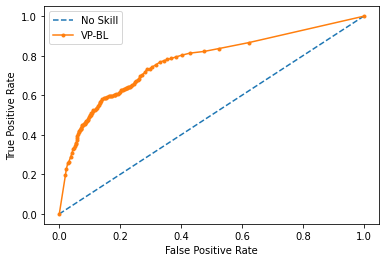

No Skill ROC AUC 0.504
Baseline ROC AUC 0.772
102
102


In [118]:
## ROC CURVE
testy = y_test2

# plot no skill roc curve
model = DummyClassifier(strategy='stratified')
model.fit(X_train, y_train2)
yhat = model.predict_proba(X_test)
pos_probs = yhat[:, 1]
roc_auc_noskill = roc_auc_score(testy, pos_probs)

pyplot.plot([0, 1], [0, 1], linestyle='--', label='No Skill')

# plot the skill curve
# retrieve just the probabilities for the positive class
pos_probs = pipeline.predict_proba(X_test)[:,1]
# calculate roc curve for model
fpr, tpr, _ = roc_curve(testy, pos_probs)

# plot model roc curve
pyplot.plot(fpr, tpr, marker='.', label=f'VP-BL')

# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')

# show the legend
pyplot.legend()

# show the plot
pyplot.show()


roc_auc = roc_auc_score(testy, pos_probs)
print('No Skill ROC AUC %.3f' % roc_auc_noskill)
print('Baseline ROC AUC %.3f' % roc_auc)
print(len(fpr))
print(len(tpr))

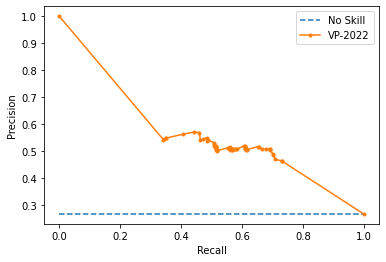

No Skill PR AUC: 0.354
Logistic PR AUC: 0.566
62
62


In [105]:
## PR Curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
y = y_test2
no_of_pos = len(y_test[y_test["vote"]=="Imod"])


# calculate the no skill line as the proportion of the positive class
no_skill = (no_of_pos / len(y))
# plot the no skill precision-recall curve
model = DummyClassifier(strategy='stratified')
model.fit(X_train, y_train)
yhat = model.predict_proba(X_test)
pos_probs = yhat[:, 1]
# calculate the precision-recall auc
precision, recall, _ = precision_recall_curve(testy, pos_probs)
auc_score_noskill = auc(recall, precision)
pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')

# calculate model precision-recall curve
pos_probs = pipeline.predict_proba(X_test)[:,1]
precision, recall, _ = precision_recall_curve(testy, pos_probs)
# plot the model precision-recall curve
pyplot.plot(recall, precision, marker='.', label=f'VP-2022')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()
auc_score = auc(recall, precision)
print('No Skill PR AUC: %.3f' % auc_score_noskill)
print('Logistic PR AUC: %.3f' % auc_score)
print(len(recall))
print(len(precision))

##### Pred and KPIs per party

In [ ]:
df_KPI = pd.DataFrame(X_test["party2"])
df_KPI["y_test"]=y_test2
df_KPI["y_pred"]=y_pred2

for party in df_KPI["party2"].unique():
    print('',party,"- Precision:", round(precision_score(df_KPI[df_KPI["party2"]==party]["y_test"], df_KPI[df_KPI["party2"]==party]["y_pred"]),2),
            "\n",party,"- Recall:", round(recall_score(df_KPI[df_KPI["party2"]==party]["y_test"], df_KPI[df_KPI["party2"]==party]["y_pred"]),2),
            "\n",party,"- AUC:", round(roc_auc_score(df_KPI[df_KPI["party2"]==party]["y_test"], df_KPI[df_KPI["party2"]==party]["y_pred"]),2),
            "\n",party,"- F1:", round(f1_score(df_KPI[df_KPI["party2"]==party]["y_test"], df_KPI[df_KPI["party2"]==party]["y_pred"]),2),
            "\n**********************")

##### Pred and KPIs per politician

In [ ]:
top_climate_voters =['Hans Kristian Skibby',
 'Bent Bøgsted',
 'Bjarne Laustsen',
 'Erling Bonnesen',
 'Torsten Schack Pedersen',
 'Benny Engelbrecht',
 'Bertel Haarder',
 'Lars Christian Lilleholt',
 'Lennart Damsbo-Andersen',
 'Liselott Blixt',
 'Mette Gjerskov',
 'Jacob Jensen',
 'Jesper Petersen',
 'Julie Skovsby',
 'Louise Schack Elholm',
 'Orla Hav',
 'Thomas Jensen',
 'Kristian Pihl Lorentzen',
 'Mikkel Dencker',
 'Ellen Trane Nørby',
 'Karsten Lauritzen',
 'Hans Andersen',
 'Magnus Heunicke',
 'Rasmus Horn Langhoff',
 'Leif Lahn Jensen',
 'Jens Joel',
 'Dennis Flydtkjær',
 'Marie Krarup',
 'Troels Lund Poulsen',
 'Karen Ellemann',
 'Pia Adelsteen',
 'Rasmus Prehn',
 'Flemming Damgaard Larsen',
 'Kim Christiansen',
 'Jan E. Jørgensen',
 'Sophie Løhde',
 'Karin Nødgaard',
 'Trine Bramsen',
 'Karina Adsbøl',
 'Eyvind Vesselbo',
 'Hans Christian Schmidt',
 'Tom Behnke',
 'Ole Birk Olesen',
 'Michael Aastrup Jensen',
 'Birgitte Josefsen',
 'Anni Matthiesen',
 'Flemming Møller Mortensen',
 'Troels Ravn',
 'Preben Bang Henriksen',
 'Jens Henrik Thulesen Dahl',
 'Morten Bødskov',
 'Karen J. Klint',
 'René Christensen',
 'Kim Andersen',
 'Ib Poulsen',
 'Inger Støjberg',
 'Marianne Jelved',
 'Eva Kjer Hansen',
 'Annette Lind',
 'Jane Heitmann',
 'Peter Juel Jensen',
 'Daniel Toft Jakobsen',
 'Henrik Dahl',
 'Karsten Nonbo',
 'Jakob Sølvhøj',
 'Christian Juhl',
 'Jørn Dohrmann',
 'Kristian Jensen',
 'Jan Johansen',
 'Karsten Hønge',
 'Brian Mikkelsen',
 'Naser Khader',
 'Thomas Danielsen',
 'Martin Henriksen',
 'Søren Krarup',
 'Mette Hjermind Dencker',
 'Astrid Krag',
 'Holger K. Nielsen',
 'Karin Gaardsted',
 'Anita Knakkergaard',
 'Alex Ahrendtsen',
 'Per Clausen',
 'Kirsten Brosbøl',
 'Lotte Rod',
 'Steen Gade',
 'Hans Christian Thoning',
 'Ulla Tørnæs',
 'Martin Geertsen',
 'Henrik Brodersen',
 'Pernille Rosenkrantz-Theil',
 'Preben Rudiengaard',
 'Marcus Knuth',
 'Tina Petersen',
 'Tina Nedergaard',
 'Rasmus Helveg Petersen',
 'Mattias Tesfaye',
 'Nick Hækkerup',
 'Lars Aslan Rasmussen',
 'Zenia Stampe',
 'Ida Auken']

In [ ]:
df_KPI = pd.DataFrame(X_test["politician"])
df_KPI["y_test"]=y_test2
df_KPI["y_pred"]=y_pred2

df_pol_KPI = pd.DataFrame()
print(len(df_KPI["politician"].unique()))


In [ ]:
df_KPI = df_KPI[df_KPI["politician"].isin(top_climate_voters)]
print(len(top_climate_voters))
print(len(df_KPI["politician"].unique()))

In [ ]:

for politician in df_KPI["politician"].unique():
    try:
        temp = pd.DataFrame()
        temp["politician"] = [politician]
        temp["Accuracy"] = [accuracy_score(df_KPI[df_KPI["politician"]==politician]["y_test"], df_KPI[df_KPI["politician"]==politician]["y_pred"])]
        temp["Precision"] = [precision_score(df_KPI[df_KPI["politician"]==politician]["y_test"], df_KPI[df_KPI["politician"]==politician]["y_pred"])]
        temp["Recall"] = recall_score(df_KPI[df_KPI["politician"]==politician]["y_test"], df_KPI[df_KPI["politician"]==politician]["y_pred"])
        temp["AUC"] = roc_auc_score(df_KPI[df_KPI["politician"]==politician]["y_test"], df_KPI[df_KPI["politician"]==politician]["y_pred"])
        temp["F1"] = f1_score(df_KPI[df_KPI["politician"]==politician]["y_test"], df_KPI[df_KPI["politician"]==politician]["y_pred"])
        df_pol_KPI = df_pol_KPI.append(temp)
    except:
        print("error", politician)
        temp = pd.DataFrame()
        temp["politician"] = [politician]
        temp["Accuracy"] = [accuracy_score(df_KPI[df_KPI["politician"]==politician]["y_test"], df_KPI[df_KPI["politician"]==politician]["y_pred"])]
        temp["Precision"] = [precision_score(df_KPI[df_KPI["politician"]==politician]["y_test"], df_KPI[df_KPI["politician"]==politician]["y_pred"])]
        temp["Recall"] = recall_score(df_KPI[df_KPI["politician"]==politician]["y_test"], df_KPI[df_KPI["politician"]==politician]["y_pred"])
        #temp["AUC"] = roc_auc_score(df_KPI[df_KPI["politician"]==politician]["y_test"], df_KPI[df_KPI["politician"]==politician]["y_pred"])
        temp["F1"] = f1_score(df_KPI[df_KPI["politician"]==politician]["y_test"], df_KPI[df_KPI["politician"]==politician]["y_pred"])
        df_pol_KPI = df_pol_KPI.append(temp)


In [ ]:
df_pol_KPI.describe()

In [ ]:
df_pol_KPI.hist()

##### Feature importance (ELI5)

In [ ]:
onehot_columns = list(pipeline.named_steps['Encode cats and scale'].named_transformers_['OneHot'].get_feature_names(input_features=["party2", "vote_caller2"]))
numeric_features_list = list(["w_for", "w_against", "cos_sim"])
numeric_features_list.extend(onehot_columns)
#numeric_features_list

In [ ]:
import eli5
eli5.explain_weights(pipeline.named_steps['classifier'], top=50, feature_names=[numeric_features_list])

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
## Link: https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance.html
categorical_columns = ["politician"]
numerical_columns = ["w_for", "w_against", "cos_sim"]
ohe = pipeline.named_steps['Encode cats and scale'].named_transformers_['OneHot']
feature_names = ohe.get_feature_names_out(categorical_columns)
feature_names = np.r_[feature_names, numerical_columns]

tree_feature_importances = pipeline.named_steps["classifier"].feature_importances_
sorted_idx = tree_feature_importances.argsort()
sorted_idx = sorted_idx[:25]

In [ ]:

y_ticks = np.arange(0, len(sorted_idx))
fig, ax = plt.subplots()
ax.barh(y_ticks, tree_feature_importances[sorted_idx])
ax.set_yticks(y_ticks)
ax.set_yticklabels(feature_names[sorted_idx])
ax.set_title("Random Forest Feature Importances (MDI)")
fig.tight_layout()
plt.show()